In [166]:
%matplotlib inline
from __future__ import division
import h5py
import numpy as np
import lockin
import sigutils
from scipy import signal, linalg
from scipy import optimize
from scipy.optimize import curve_fit
import matplotlib as mpl
mpl.style.use('classic')
import matplotlib.pyplot as plt
from matplotlib import gridspec
import phasekick
import glob
import collections
from tqdm import tqdm
import pandas as pd
idx = pd.IndexSlice

def svdsqrtm(x, eps=1e-15):
    """Return the matrix square root of x calculating using the svd.
    
    Set singular values < eps to 0.
    This prevents numerical errors from making sqrtm(x) complex
    (small eigenvalues of x accidently negative)."""
    u, s, v = linalg.svd(x)
    s_pos = np.zeros_like(s)
    for i in xrange(s.size):
        if s[i] > eps:
            s_pos[i] = s[i]

    return np.dot(u, np.dot(np.diag(np.sqrt(s_pos)), v.T))


def unscented(x, P, scale=1.0, eps=1e-15):
    u""""For a vector x of length N with covariance matrix P,
    form 2N sigma points used for taking the unscented transform.

                                      __
    Defaults to taking points at x ± √NP."""
    x = x.ravel() # Force shape
    N = x.size
    Psqrt = scale * svdsqrtm(N * P, eps)
    x_sigma = []

    for i in xrange(N):
        x_sigma.append(x + Psqrt[:, i])

    for i in xrange(N):
        x_sigma.append(x - Psqrt[:, i])

    return x_sigma

def gr2locks(top_gr):
    locks = []
    for gr in tqdm(top_gr.values()):
        half_periods = gr["half periods [s]"][:]
        N2even = gr.attrs['Calc BNC565 CantClk.N2 (even)']
        t1 = gr.attrs['Abrupt BNC565 CantClk.t1 [s]']
        t2 = np.sum(gr["half periods [s]"][:N2even+1])
        t0 = -(t1 + t2)
        x = gr['cantilever-nm'][:]
        dt = gr['dt [s]'].value
        t = np.arange(x.size)*dt + t0
        lock = lockin.LockIn(t, x, 1/dt)
        lock.lock2(fp=5000, fc=15000, print_response=False)
        lock.phase(ti=3e-3, tf=7e-3)
        locks.append(lock)
    
    return locks


def left_right_fit(x, y, xLi, xLf, xRi, xRf, x0):
    mL = phasekick.masklh(x, xLi, xLf)
    mR = phasekick.masklh(x, xRi, xRf)
    mbL = np.polyfit(x[mL], y[mL], 1)
    mbR = np.polyfit(x[mR], y[mR], 1)
    diff = np.polyval(mbR, x0) - np.polyval(mbL, x0)
    return mbL, mbR, diff

def measure_dA_dphi(li, tp, tLi, tLf, tRi, tRf):
    _, __, dA = left_right_fit(li.t, li.A, tLi, tLf, tp+tRi, tp+tRf, tp/2)
    _, __, dphi = left_right_fit(li.t, np.unwrap(li.phi), tLi, tLf, tp+tRi, tp+tRf, tp/2)
    return dA, dphi



def avg_psd(lias):
    psd = []
    for lia in lias:
        freq, psd_ = signal.periodogram(lia.x, fs=1e6)
        psd.append(psd_)
    psd = np.array(psd)
    return freq, np.mean(psd, axis=0)

class LIAvg(object):
    def __init__(self, lis):
        self.lis = lis
    
    def __getattr__(self, attr):
        if isinstance(getattr(self.lis[0], attr), collections.Iterable):
            return np.mean(np.array([getattr(li, attr)[li.m0] for li in self.lis]), axis=0)
        else:
            return np.mean([getattr(li, attr) for li in self.lis])

def cumsum_zero(x, i):
    cumsum = np.cumsum(x)
    return cumsum - cumsum[i] 
        
def delay_dA_dphi(top_gr, tp, tLi, tLf, tRi, tRf):
    dAs=[]
    dPhis=[]
    delays =[]
    for ds_name, gr in tqdm(top_gr.items()):
        half_periods = gr["half periods [s]"][:]
        N2even = gr.attrs['Calc BNC565 CantClk.N2 (even)']
        t1 = gr.attrs['Abrupt BNC565 CantClk.t1 [s]']
        t2 = np.sum(gr["half periods [s]"][:N2even+1])
        t0 = -(t1 + t2)
        x = gr['cantilever-nm'][:]
        dt = gr['dt [s]'].value
        t = np.arange(x.size)*dt + t0
        li = lockin.LockIn(t, x, 1/dt)
        li.lock2(fp=5000, fc=15000, print_response=False)
        li.phase(ti=3e-3, tf=7e-3)
        dA, dphi = measure_dA_dphi(li, tp, tLi, tLf, tRi, tRf)
        dAs.append(dA)
        dPhis.append(dphi)
        delays.append(gr.attrs['Abrupt BNC565 CantClk.D tip [s]'])
    
    return delays, dAs, dPhis

def gr2lock_both(fh, ds, f1, f2, t1=-1e-3, t2=4e-3, iir=None):
    lis = []
    for gr in ['data', 'control']:
        li = phasekick.gr2lock(fh[gr][ds], f1, f2)
        if iir is not None:
            li.lock_butter(**iir)
            li.phase(ti=0.003)
        li.m0 = phasekick.masklh(li.t, t1, t2)
        lis.append(li)
    
    return LIAvg(lis)

def align_labels(axes_list,lim, axis='y'):
    for ax in axes_list:
        t = ax.yaxis.label.get_transform()
        x,y = ax.yaxis.label.get_position()
        ax.yaxis.set_label_coords(lim,y,t)

In [115]:
size = 9
rcParams = {'figure.figsize': (2.0, 2.5), 'font.size': size,
#             'lines.markersize': ,
            'lines.linewidth': 1,
            'xtick.labelsize': size, 'ytick.labelsize': size,}

In [3]:
fh = h5py.File('../data/subcycle-pk-efm/151209-192456-400ns-pulse-10V.h5', 'r')
delays, dA, dPhis = delay_dA_dphi(fh['data'], 1.6e-3, -1e-3, -1e-4, 1e-4, 1e-3)

tps = [800, 400, 200, 100, 50]
# Set up DataFrame now that delay times are known
delay_int = np.int64(np.round(np.array(delays)*1e9))
df = pd.DataFrame(index=pd.MultiIndex.from_product(
        ([800, 400, 200, 100, 50], delay_int), names=['pulsewidth', 'delay']))
df.sort_index(inplace=True)

df.loc[idx[400, :], 'dA'] = dA
df.loc[idx[400, :], 'dPhi'] = dPhis

fh100 = h5py.File('../data/subcycle-pk-efm/151209-192746-100ns-pulse-10V.h5', 'r')
delays, dAs, dPhis = delay_dA_dphi(fh100['data'], 1.6e-3, -1e-3, -1e-4, 1e-4, 1e-3)
df.loc[idx[100, :], 'dA'] = dAs
df.loc[idx[100, :], 'dPhi'] = dPhis

fh50 = h5py.File('../data/subcycle-pk-efm/151209-193134-050ns-pulse-10V.h5', 'r')
delays, dAs, dPhis = delay_dA_dphi(fh50['data'], 1.6e-3, -1e-3, -1e-4, 1e-4, 1e-3)
df.loc[idx[50, :], 'dA'] = dAs
df.loc[idx[50, :], 'dPhi'] = dPhis

fh800 = h5py.File('../data/subcycle-pk-efm/151209-192327-800ns-pulse-10V.h5', 'r')
delays, dAs, dPhis = delay_dA_dphi(fh800['data'], 1.6e-3, -1e-3, -1e-4, 1e-4, 1e-3)
df.loc[idx[800, :], 'dA'] = dAs
df.loc[idx[800, :], 'dPhi'] = dPhis

fh200 = h5py.File('../data/subcycle-pk-efm/151209-192620-200ns-pulse-10V.h5', 'r')
delays, dAs, dPhis = delay_dA_dphi(fh200['data'], 1.6e-3, -1e-3, -1e-4, 1e-4, 1e-3)
df.loc[idx[200, :], 'dA'] = dAs
df.loc[idx[200, :], 'dPhi'] = dPhis


100%|██████████| 64/64 [00:02<00:00, 26.65it/s]


In [4]:
locks = []
fir = lockin.lock2(62000, 5000, 15000, 1e6)
for gr in tqdm(fh800['data'].values()):
    half_periods = gr["half periods [s]"][:]
    N2even = gr.attrs['Calc BNC565 CantClk.N2 (even)']
    t1 = gr.attrs['Abrupt BNC565 CantClk.t1 [s]']
    t2 = np.sum(gr["half periods [s]"][:N2even+1])
    t0 = -(t1 + t2)
    x = gr['cantilever-nm'][:]
    dt = gr['dt [s]'].value
    t = np.arange(x.size)*dt + t0
    lock = lockin.LockIn(t, x, 1/dt)
    lock.lock2(fp=5000, fc=15000, print_response=False)
    lock.phase(ti=3e-3, tf=7e-3)
    locks.append(lock)
    m0 = phasekick.masklh(t, -5e-6, 5e-6) 

  5%|▍         | 3/64 [00:00<00:02, 26.01it/s]

Response:
f   mag       dB
    0.000 1.000   -0.000
 2500.000 0.978   -0.189
 5000.000 0.897   -0.942
15000.000 0.113  -18.951
30000.000 0.000  -97.678
31000.000 0.000 -101.316
62000.000 0.000 -126.825
500000.000 0.000 -191.988


100%|██████████| 64/64 [00:02<00:00, 24.93it/s]


In [15]:
factor = 2/1.92
# Apply 4e3, 15e3 filter;
# Add iir filter of specified bandwidth.
fmax = 6e3
lia = gr2lock_both(fh, '0000', 4e3*factor, 15e3*factor, iir=dict(N=2, f3dB=fmax/4.5, t_exclude=1e-3))
lia1 = gr2lock_both(fh, '0000', 4e3*factor, 15e3*factor, iir=dict(N=2, f3dB=fmax/4.5, t_exclude=1e-3))
lia4 = gr2lock_both(fh, '0000', 4e3*factor, 15e3*factor, iir=dict(N=2, f3dB=fmax, t_exclude=1e-3))

Response:
f   mag      dB
    0.000 1.000  -0.000
  666.667 0.970  -0.263
 1333.333 0.707  -3.010
30964.231 0.002 -54.692
61928.462 0.000 -66.899
500000.000 0.000    -inf
Response:
f   mag      dB
    0.000 1.000  -0.000
  666.667 0.970  -0.263
 1333.333 0.707  -3.010
30964.102 0.002 -54.692
61928.204 0.000 -66.899
500000.000 0.000    -inf
Response:
f   mag      dB
    0.000 1.000  -0.000
  666.667 0.970  -0.263
 1333.333 0.707  -3.010
30964.231 0.002 -54.692
61928.462 0.000 -66.899
500000.000 0.000    -inf
Response:
f   mag      dB
    0.000 1.000  -0.000
  666.667 0.970  -0.263
 1333.333 0.707  -3.010
30964.102 0.002 -54.692
61928.204 0.000 -66.899
500000.000 0.000    -inf
Response:
f   mag      dB
    0.000 1.000  -0.000
 3000.000 0.970  -0.263
 6000.000 0.707  -3.010
30964.231 0.037 -28.567
61928.462 0.009 -40.769
500000.000 0.000    -inf
Response:
f   mag      dB
    0.000 1.000  -0.000
 3000.000 0.970  -0.263
 6000.000 0.707  -3.010
30964.102 0.037 -28.567
61928.204 0.009 -40.769

In [219]:
1/(1/6**2 + 1/8**2)**0.5

4.8

In [220]:
1/(1/1.5**2 + 1/8**2)**0.5

1.4743082804014829

In [16]:
lia = gr2lock_both(fh, '0000', 4e3*factor, 15e3*factor, iir=dict(N=2, f3dB=fmax/4.5, t_exclude=1e-3))

Response:
f   mag      dB
    0.000 1.000  -0.000
  666.667 0.970  -0.263
 1333.333 0.707  -3.010
30964.231 0.002 -54.692
61928.462 0.000 -66.899
500000.000 0.000    -inf
Response:
f   mag      dB
    0.000 1.000  -0.000
  666.667 0.970  -0.263
 1333.333 0.707  -3.010
30964.102 0.002 -54.692
61928.204 0.000 -66.899
500000.000 0.000    -inf


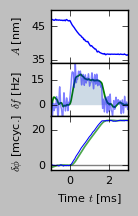

In [140]:
mpl.rc('font', size=8)
    
fig, (ax2, ax3, ax4) = plt.subplots(nrows=3, figsize=(1., 2.))
fig.subplots_adjust(hspace=0, wspace=0)

lock = locks[48]
m2 = phasekick.masklh(lock.t, -1e-6, 8e-6)
m = phasekick.masklh(lock.t, -3e-3, 4.6e-3)

t_many = np.linspace(lock.t[m2][0], lock.t[m2][-1], 3001) * 1e6  
ti = 16/4.0


m_fill1 = phasekick.masklh(lia.t, -2e-4, 2e-3)
m_fill4 = phasekick.masklh(lia4.t, -2e-4, 2e-3)
i0 = np.argmax(abs(lia.t) <= 0.5e-6) # Index where t = 0
ax = [ax3, ax4]

ax[0].fill_between(lia4.t[m_fill4]*1e3, lia4.df[m_fill4],
                   color='b', alpha='0.1', linewidth=0) 
ax[0].fill_between(lia.t[m_fill1]*1e3, lia.df[m_fill1],
                   color='g', alpha='0.1', linewidth=0) 
ax[0].plot(lia4.t*1e3, lia4.df, 'b', linewidth=1, alpha=0.5)
ax[0].plot(lia.t*1e3, lia.df, 'g', alpha=1, linewidth=1.25, zorder=0)
# ax[0].plot(lia1.t*1e3, lia1.df, 'm', linewidth=1.5, zorder=0)
ax[1].plot(lia4.t*1e3, cumsum_zero(lia4.df, i0)*1e-3, 'b', linewidth=0.75, alpha=1, zorder=2)
ax[1].plot(lia.t*1e3, cumsum_zero(lia.df, i0)*1e-3, 'g', alpha=0.7, linewidth=1.25, zorder=1)
# ax[1].plot(lia1.t*1e3, cumsum_zero(lia1.df, i0)*1e-3, 'm', alpha=0.5, linewidth=1.75, zorder=0)
# ax[1].set_xlabel("Time [ms]")
ax[0].set_ylabel("$\\delta f$ [Hz]")
ax[0].set_ylim(-7, 25)
ax[1].set_ylabel("$\\delta \\phi$ [mcyc.]")
# ax[1].set_xlim(-0.5, 2.5)
# ax[0].set_xlim(-0.5, 2.5)
ax[1].set_ylim(-2.5, 27.5)
ax[1].set_yticks(np.linspace(0, 20, 2))
ax[0].set_yticks(np.linspace(0, 15, 2))
ax[1].axhline(y=0, color='0.5', linewidth=1, zorder=0)
# ax[0].set_xticklabels([""])
# ax[1].set_xticklabels(["", 0, "", 1, "", 2, ""])

ax2.plot(lock.t[m]*1e3, lock.A[m], 'b')
# ax2.set_xlim(-3, 4.6)
# ax2.set_xticks(np.arange(-2, 5.25, 2))
ax2.set_yticks(np.arange(35, 46, 10))

# ax2.set_yticks(np.arange(35, 46, 5))
ax2.set_ylabel("$A$ [nm]")
ax2.set_xticklabels([''])
ax3.set_xticklabels([''])
for ax in [ax2, ax3, ax4]:
    ax.set_xlim(-1, 3)
    ax.set_xticks([0, 2])

# ax4.set_xticklabels(['0', '2'])
ax4.set_xlabel("Time $t$ [ms]")
#     fig.savefig("/Users/ryandwyer/Dropbox/_JAM_GT__Marohn201610__NSF_DMR__renewal__figs/_rawfigs/Avst.pdf",
#                 bbox_inches='tight', transparent=True)

In [141]:
align_labels([ax2, ax3, ax4], 15)

In [142]:
for (ax_, yloc) in zip([ax2, ax3, ax4],
                        [0.5, 0.53, 0.4]):
    yaxis = ax_.get_yaxis()
    x, y = yaxis.label.get_position()
    yaxis.label.set_position((x, yloc))

In [143]:
fig.savefig('ex.pdf', bbox_inches='tight', pad_inches=0.25, transparent=True)

In [144]:
!open ex.pdf

In [145]:
!cp ex.pdf /Users/ryandwyer/Dropbox/_JAM_MS__Dwyer201511__Phasekick__figs/raw-figures/pk-EFM-subcycle-D-df-dphi.pdf

In [146]:
locks = gr2locks(fh800['data'])

100%|██████████| 64/64 [00:02<00:00, 27.46it/s]


In [147]:
m800 = np.array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False, False], dtype=bool)

m400 = np.array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True, False], dtype=bool)

In [148]:
delay_us = delay_int / 1000.0

In [149]:
dAfunc = lambda f, tau, A0: phasekick.phase_step(1.0/f, tau, A0) * f

In [150]:
fit_func = lambda t, A1, A2, dphi, offset: A1*np.cos(2*np.pi*0.062e-3*t + dphi)*(1+A2*np.sin(2*np.pi*0.062e-3*t+dphi)) + offset

In [151]:
tt = np.arange(2000)*1e-8

In [152]:
df.sort_index(inplace=True)

In [153]:
# # plt.plot(delay_int, df.loc[idx[800, :], 'dPhi'])
# plt.plot(delay_int, df.loc[idx[400, :]*2, 'dPhi'])
# plt.plot(delay_int, df.loc[idx[200, :]*4, 'dPhi'])
# plt.plot(delay_int, df.loc[idx[100, :]*8, 'dPhi'])
# plt.plot(delay_int, df.loc[idx[50, :]*16, 'dPhi'])

In [154]:
pulsewidths = np.array([800, 400, 200, 100, 50.])

In [155]:
df_i = df.xs(50, level='pulsewidth', drop_level=True)

In [156]:
dA_fit = []
dA_fit_std_err = []
dAopts = []
dAfunc_off = lambda t, A, phi, offset: offset + A*np.cos(2*np.pi*t*0.062 + 2*np.pi*phi)
for i, pulsewidth in enumerate(pulsewidths):
    df_i = df.xs(pulsewidth, level='pulsewidth', drop_level=True)
    if i == 0:
        x = df_i.index[m800]/1000.
        y = df_i.dA.values[m800]
    elif i == 1:
        x = df_i.index[m400]/1000.
        y = df_i.dA.values[m400]
    else:
        x = df_i.index/1000.
        y = df_i.dA.values

    popt, pcov = curve_fit(dAfunc_off,
    x, y, p0=[pulsewidth/40, -0.1, 0])
    dAopts.append(popt)
    dA_std_err = np.sqrt(pcov.diagonal())[0]
    dA_fit.append(popt[0])
    dA_fit_std_err.append(dA_std_err)

dA_fit = np.array(dA_fit)
dA_fit_stbd_err = np.array(dA_fit_std_err)

In [157]:
f = 1000.0/np.array(tps) # units µs^{-1}

In [190]:
cov_pts = unscented(popt, pcov, 2)

In [191]:
cov_pts

[array([  4.16533601e-02,   5.50647151e+01]),
 array([  4.54592020e-02,   6.00521256e+01]),
 array([  2.65111879e-02,   5.50419613e+01]),
 array([  2.27053459e-02,   5.00545508e+01])]

In [192]:
pcov.diagonal()**0.5

array([ 0.00483161,  1.76734281])

In [193]:
sigma_pts_y = np.c_[[dAfunc(f_smooth, *p) for p in cov_pts]]

In [194]:
sigma_pts_y.min(axis=0)

array([ 48.91804488,  48.64528347,  48.37252205,  48.09976064,
        47.82699923,  47.55423782,  47.28147644,  47.00871521,
        46.7359545 ,  46.46319534,  46.19043989,  45.91769234,
        45.64495975,  45.37225313,  45.09958834,  44.57112011,
        44.04137528,  43.51633612,  42.99644135,  42.48209012,
        41.97363965,  41.47140445,  40.97565681,  40.48662815,
        40.00451097,  39.5294613 ,  39.06160131,  38.60102213,
        38.14778659,  37.70193201,  37.26347276,  36.83240282,
        36.4086981 ,  35.99231859,  35.58321038,  35.18130752,
        34.78653361,  34.39880339,  34.01802402,  33.64409639,
        33.27691614,  32.91637465,  32.56235994,  32.2147574 ,
        31.87345049,  31.53832133,  31.20925122,  30.88612112,
        30.56881202,  30.25720532,  29.95118313,  29.65062849,
        29.35542564,  29.06546018,  28.78061925,  28.50079164,
        28.22586793,  27.95574055,  27.69030387,  27.42945426,
        27.17309012,  26.92111192,  26.6734222 ,  26.42

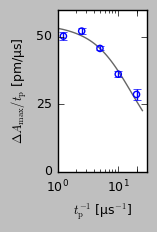

In [215]:
dA_norm = dA_fit * f
dA_norm_err = dA_fit_std_err * f
popt, pcov = optimize.curve_fit(dAfunc, f, dA_norm, sigma=dA_norm_err, p0=np.array([0.029, 53]))
f_smooth = np.linspace(1, 25, 101)
# with mpl.rc_context(rcParams):

f = 1000*pulsewidths**-1
fig = plt.figure(figsize=(1.65, 2.4))
plt.scatter(f, dA_fit/pulsewidths*1e3, facecolors='none', edgecolors='b')
plt.errorbar(f, dA_fit/pulsewidths*1e3, yerr=dA_fit_std_err/pulsewidths*2 * 1e3, fmt='none')
plt.xlabel(u"$t_\\mathrm{p}^{-1}$ [µs${}^{-1}$]")
plt.ylabel(u"$\Delta A_{\\mathrm{max}}/t_\\mathrm{p}$ [pm/µs]")
plt.ylim(0, 60)
plt.yticks(np.arange(0, 55, 25))
plt.xlim(1, 30)
plt.xscale('log')
plt.xticks([1, 10, 20])
#     plt.plot(f_smooth, 55/(1 + (f_smooth/20)), '0.5', zorder=0.5)
plt.plot(f_smooth, dAfunc(f_smooth, *popt), '0.4', zorder=0)
#     plt.fill_between(f_smooth, sigma_pts_y.min(axis=0),
#                      sigma_pts_y.max(axis=0), zorder=0, color='0.6', alpha=0.5)
plt.tight_layout()
#     plt.savefig('/Users/ryandwyer/Dropbox/_JAM_GT__Marohn201610__NSF_DMR__renewal__figs/_rawfigs/dA-vs-tp-filter-rolloff.pdf',
#                 bbox_inches='tight', transparent=True)

#     plt.savefig('/Users/ryandwyer/Dropbox/_JAM_GT__Marohn201610__NSF_DMR__renewal__figs/_rawfigs/dA-vs-tp-filter-rolloff-fit.pdf',
#                 bbox_inches='tight', transparent=True)

In [216]:
fig.savefig('/Users/ryandwyer/Dropbox/_JAM_MS__Dwyer201511__Phasekick__figs/raw-figures/dA-vs-tp-filter-rolloff-fit.pdf',
            bbox_inches='tight', transparent=True)

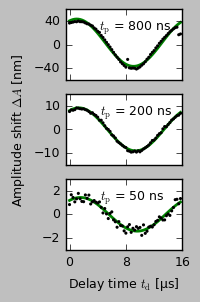

In [213]:
# fmt= dict(s=8, c='none', edgecolors='k')
mpl.rc('font', size=9)
fmt= dict(marker='.', c='k', edgecolors='none', zorder=1)
fmt_bestfit = dict(color='g', zorder=0, linewidth=2)


fig, axes = plt.subplots(figsize=(1.5, 3.0), nrows=3, sharex=True)
axes[0].plot(delay_us, dAfunc_off(delay_us, *dAopts[0]), **fmt_bestfit)
axes[0].scatter(delay_us, df.loc[idx[800, :], 'dA'], **fmt)
axes[0].set_yticks(np.arange(-40, 45, 40))
axes[0].text(4.2, 24.5, "$t_\\mathrm{p}$ = 800 ns")

axes[1].plot(delay_us, dAfunc_off(delay_us, *dAopts[2]), **fmt_bestfit)
axes[1].scatter(delay_us, df.loc[idx[200, :], 'dA'], **fmt)
axes[1].set_yticks(np.arange(-10, 15, 10))
axes[1].text(4.3, 6.1, "$t_\\mathrm{p}$ = 200 ns")

axes[2].plot(delay_us, dAfunc_off(delay_us, *dAopts[4]), **fmt_bestfit)
axes[2].scatter(delay_us, df.loc[idx[50, :], 'dA'], **fmt)
axes[2].text(4.3, 1.2, "$t_\\mathrm{p}$ = 50 ns")
axes[2].set_yticks(np.arange(-2, 2.5, 2))
axes[0].set_xlim(-0.5, 16)
axes[2].set_xticks([0, 8, 16])
axes[2].set_xlabel(u"Delay time $t_\\mathrm{d}$ [µs]")
axes[1].set_ylabel(u"Amplitude shift $\\Delta A$ [nm]")
    


In [214]:
fig.savefig('/Users/ryandwyer/Dropbox/_JAM_MS__Dwyer201511__Phasekick__figs/raw-figures/dA-v-td.pdf',
                bbox_inches='tight', transparent=True)